In [1]:
import os
import pandas as pd
import numpy as np
import pickle

In [2]:
with open('dataframe_clean.pkl', 'rb') as f:
    df = pickle.load(f)

In [3]:
df = df.drop(columns='Sample_Weights')
df

,Good_Health,Health_Insurance,Hypertension,High_Cholesterol,Asthma_Status,Arthritis,Race,Age_Cat,BMI_Cat,Education_Level,...,Pneumonia_Vaccine,HIV,Bronchitis,Depression,Kidney_Disease,Diabetes,SEX,Marital_Status,Sodium,Heart_Disease
0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,4.0,2.0,...,65.0,1.0,1.0,1.0,2.0,2.0,2.0,1.0,999.0,0.0
1,1.0,2.0,2.0,2.0,3.0,2.0,1.0,4.0,3.0,4.0,...,65.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0
3,2.0,1.0,1.0,1.0,3.0,1.0,1.0,5.0,3.0,2.0,...,65.0,9.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,0.0
4,2.0,1.0,2.0,2.0,3.0,1.0,1.0,5.0,2.0,3.0,...,65.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,0.0
5,1.0,9.0,1.0,2.0,3.0,1.0,1.0,6.0,3.0,1.0,...,1.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441451,2.0,9.0,1.0,1.0,3.0,1.0,5.0,6.0,1.0,1.0,...,2.0,2.0,2.0,2.0,2.0,1.0,2.0,3.0,1.0,0.0
441452,1.0,1.0,2.0,2.0,3.0,2.0,5.0,2.0,3.0,3.0,...,65.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,0.0
441453,2.0,9.0,1.0,1.0,3.0,2.0,5.0,6.0,4.0,2.0,...,9.0,999.0,2.0,2.0,2.0,2.0,2.0,1.0,999.0,0.0
441454,1.0,1.0,1.0,2.0,3.0,2.0,5.0,4.0,2.0,3.0,...,65.0,2.0,2.0,2.0,2.0,2.0,1.0,5.0,1.0,0.0


In [4]:
df.columns

Index(['Good_Health', 'Health_Insurance', 'Hypertension', 'High_Cholesterol',
       'Asthma_Status', 'Arthritis', 'Race', 'Age_Cat', 'BMI_Cat',
       'Education_Level', 'Income_Level', 'Smoker_Status', 'Heavy_Drinker',
       'Physical_Activity', 'Seatbelt', 'Flu_Shot', 'Pneumonia_Vaccine', 'HIV',
       'Bronchitis', 'Depression', 'Kidney_Disease', 'Diabetes', 'SEX',
       'Marital_Status', 'Sodium', 'Heart_Disease'],
      dtype='object')

In [5]:
from pgmpy.models.BayesianNetwork import BayesianNetwork
from pgmpy.estimators import StructureEstimator, HillClimbSearch

class BayesianModel(BayesianNetwork):
    cls = {'graph_search_algo':None, \
           'graph_search_params':{}, \
           'X':pd.DataFrame(), \
           'y':pd.Series(dtype=float), \
           'dag':None}

    def __init__(self, *, ebunch=None, graph_search_algo=HillClimbSearch, graph_search_params={}, **params):
        super().__init__(ebunch)
        
        if ebunch == None:
            self.graph_search_algo = graph_search_algo
            self.graph_search_params = graph_search_params
        else:
            self.graph_search_algo = None
            self.graph_search_params = None

        self.params = params

    def fit(self, X, y, **fit_params):
        skip_search_graph = True
        skip_search_graph = BayesianModel.cls['graph_search_algo'] == self.graph_search_algo
        if skip_search_graph:
            skip_search_graph = BayesianModel.cls['graph_search_params'] == self.graph_search_params
        if skip_search_graph:
            if BayesianModel.cls['X'].shape == X.shape:
                if (BayesianModel.cls['X'].columns == X.columns).all() and (BayesianModel.cls['X'].index == X.index).all():
                    skip_search_graph = (BayesianModel.cls['X'] == X).all().all()
                else:
                    skip_search_graph = False
            else:
                skip_search_graph = False
        if skip_search_graph:
            skip_search_graph = (BayesianModel.cls['y'] == y).all()
        
        data = pd.concat([X, y], axis=1)
        if not skip_search_graph:
            graph_search_est = self.graph_search_algo(data)
            dag = graph_search_est.estimate(**self.graph_search_params)
            super().__init__(dag)

            BayesianModel.cls['graph_search_algo'] = self.graph_search_algo
            BayesianModel.cls['graph_search_params'] = self.graph_search_params
            BayesianModel.cls['X'] = X
            BayesianModel.cls['y'] = y
            BayesianModel.cls['dag'] = dag
        else:
            print('Graph Searching has been skipped')
            super().__init__(BayesianModel.cls['dag'])

        if len(fit_params) != 0:
            params = {**self.params, **fit_params}
        else:
            params = self.params
        
        print('Now fitting the graph...')
        super().fit(data, **params)
        print('Succesfully fitted the graph')

    def predict(self, X, stochastic=False, n_jobs=-1):
        y_pred = super().predict(X, stochastic, n_jobs)

        if y_pred.shape[1] == 1:
            y_pred = y_pred.iloc[:, 0]

        return y_pred

    def predict_proba(self, X):
        return super().predict_probability(X)
    
    def get_params(self, deep=False):
        return {'graph_search_algo':self.graph_search_algo, 'graph_search_params':self.graph_search_params, **self.params}

In [6]:
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate

def cv_scorer(ml_algo, scoring, *data, model_name=None, algo_params={}, resampler=None, output=True):    
    if len(data) == 2:
        X, y = tuple(data)
        w = None
    elif len(data) == 3:
        X, y, w = tuple(data)
    else:
        print('Invalid length for "data".')
        return
    
    if resampler != None:
        model = Pipeline([('Resampling', resampler()), (model_name, ml_algo(**algo_params))])
    else:
        model = Pipeline([(model_name, ml_algo(**algo_params))])
    
    cv_scores = cross_validate(model, X, y, scoring=scoring, fit_params={}, return_estimator=True)
    if output == True:
        if type(model_name) != type(None):
            print(model_name + ' cv_scores:')
        else:
            print('cv_scores:')
        print(cv_scores)
        print()
    
    cv_scores_summary = {}
    cv_scores_summary['estimator'] = cv_scores['estimator']
    for score in scoring:
        scores_ = cv_scores['test_' + score]
        mean_ = cv_scores['test_' + score].mean()
        std_ = cv_scores['test_' + score].std()
        
        cv_scores_summary[score]= dict(zip(['scores', 'mean', 'std'], [scores_, mean_, std_]))
        
        if output == True:
            print(score + ' mean: ' + f'{mean_:0.2f}')
            print(score + ' std: ' + f'{std_:0.4f}')
            print()
    if print == True:
        print()
    
    if type(model_name) != type(None):
        return {model_name:cv_scores_summary}, cv_scores
    else:
        return cv_scores_summary, cv_scores

In [7]:
from sklearn.model_selection import train_test_split

X = df.drop(columns='Heart_Disease')
y = df['Heart_Disease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [8]:
from pgmpy.estimators import BayesianEstimator

bm = BayesianModel(graph_search_algo=HillClimbSearch, graph_search_params={}, estimator=BayesianEstimator, prior_type='BDeu', equivalent_sample_size=5)
bm.fit(X_train, y_train)
y_pred = bm.predict(X_test)
y_pred

  0%|          | 0/1000000 [00:00<?, ?it/s]

Now fitting the graph...
Succesfully fitted the graph


  0%|          | 0/79444 [00:00<?, ?it/s]

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
87498    0.0
87499    0.0
87500    0.0
87501    0.0
87502    0.0
Name: Heart_Disease, Length: 87503, dtype: float64

In [17]:
y_proba = bm.predict_proba(X_test)
y_proba

,Heart_Disease_0.0,Heart_Disease_1.0
0,0.999189,0.000811
1,0.976022,0.023978
2,0.965181,0.034819
3,0.996295,0.003705
4,0.996255,0.003745
...,...,...
87498,0.999159,0.000841
87499,0.995123,0.004877
87500,0.866170,0.133830
87501,0.949793,0.050207


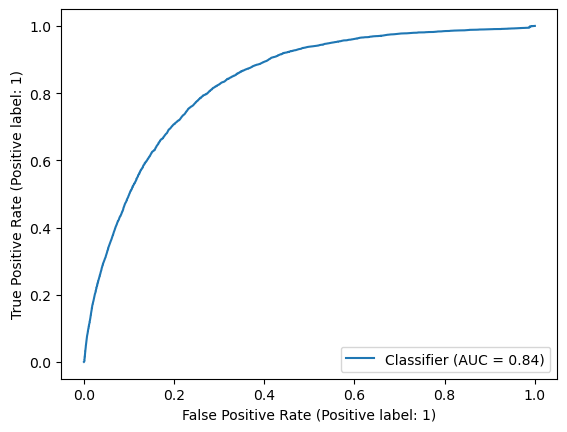

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_test, y_proba.iloc[:, 1])
plt.show()

In [31]:
with open('./y_pred.pkl', 'wb') as f:
    pickle.dump(y_pred, f)

with open('./y_proba.pkl', 'wb') as f:
    pickle.dump(y_proba, f)

In [ ]:
scores = cross_validate(BayesianModel(graph_search_algo=HillClimbSearch, graph_search_params={}, estimator=BayesianEstimator, prior_type='BDeu', equivalent_sample_size=5), \
    X, y, scoring=['recall', 'roc_auc'])
scores

In [ ]:
cv_scores_summary, cv_scores = cv_scorer(BayesianModel, ['recall'], X, y, model_name='BayesianModel', algo_params=dict(graph_search_algo=HillClimbSearch, \
    graph_search_params={'tabu_length':200, 'max_iter':20}, estimator=BayesianEstimator, prior_type='BDeu', equivalent_sample_size=5), resampler=None, output=True)

In [ ]:
from pgmpy.models.BayesianNetwork import BayesianNetwork

path = 'best_model.bif'
path_exists = os.path.exists(path)

if not path_exists:
    from pgmpy.estimators import HillClimbSearch, BayesianEstimator
    
    data_train = pd.concat([X_train, y_train], axis=1)
    est = HillClimbSearch(data_train)
    best_model = BayesianNetwork(est.estimate())
    best_model.fit(data_train, estimator=BayesianEstimator, prior_type='BDeu', equivalent_sample_size=5)
    del(data_train)
    best_model.save('best_model.bif', filetype='bif')
    print('Best model trained.')
else:
    
    best_model = BayesianNetwork.load('best_model.bif', filetype='bif')
    print('Best model loaded.')

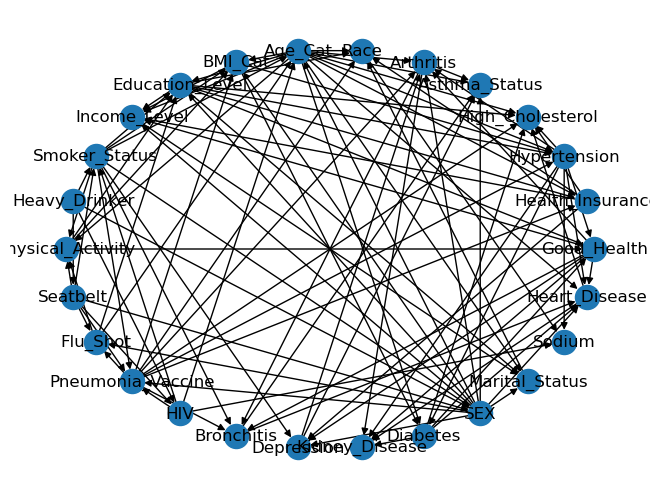

In [10]:
import networkx as nx

nx.draw_kamada_kawai(bm, with_labels=True)

In [ ]:
path = 'y_predictions.pkl'
path_exists = os.path.exists(path)

if not path_exists:
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_probability(X_test)

    with open(path, 'wb') as f:
        pickle.dump(2, f)
        pickle.dump(y_pred, f)
        pickle.dump(y_pred_proba, f)

else:
    with open(path, 'rb') as f:
        _ = pickle.load(f)
        y_pred = pickle.load(f)
        y_pred_proba = pickle.load(f)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_test, y_pred_proba.iloc[:, 1])
plt.show()

In [ ]:
from sklearn.metrics import roc_curve

def find_threshold(fpr_chosen):
    fpr, _, thresholds= roc_curve(y_test, y_pred_proba.iloc[:, 1])
    indices = np.where(fpr <= fpr_chosen)[0]
    index = indices[-1:-2:-1][0] + 1
    return thresholds[index]

def predict_with_treshold(proba, threshold):
    return (proba >= threshold).astype(float)

In [ ]:
y_pred_2 = predict_with_treshold(y_pred_proba.iloc[:, 1], find_threshold(0.2))

In [ ]:
y_pred_2.value_counts()

In [ ]:
print(classification_report(y_test, y_pred_2))

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_2, normalize='true')
plt.show()

In [ ]:
print('Node', 'Parents', 'InDegree')
for node in best_model.nodes:
    parents = best_model.get_parents(node)
    print(node, parents, len(parents))

In [ ]:
from pgmpy.inference.CausalInference import CausalInference

inference = CausalInference(best_model)

In [ ]:
phi = inference.query(['Heart_Disease'], do={'Hypertension':2.0})

In [ ]:
print(phi)

In [ ]:
inference.estimate_ate('Hypertension', 'Heart_Disease', data_train)

**Testing Active Trail Function**

In [ ]:
toy_model = BayesianNetwork([('Difficulty', 'Grade'), ('Intelligence', 'Grade'),('Intelligence', 'SAT'), ('Grade', 'Letter')])

In [ ]:
toy_model.get_random_cpds(n_states = {'Difficulty':2, 'Intelligence':2, 'Grade':5, 'SAT':2, 'Letter':2}, inplace=True)

In [ ]:
help(BayesianNetwork)

In [ ]:
nx.draw_kamada_kawai(toy_model, with_labels=True)

In [ ]:
for node in toy_model.nodes:
    print(toy_model.active_trail_nodes(node, []))

In [ ]:
toy_model.nodes

In [ ]:
toy_model.states

In [ ]:
df_toy = pd.DataFrame(index=[0])

In [ ]:
df_toy

In [ ]:
toy_model.predict_probability(df_toy)

In [ ]:
toy_model.active_trail_nodes(['SAT'])

In [ ]:
from pgmpy.inference.CausalInference import CausalInference
inference = CausalInference(toy_model)

In [ ]:
for i in range(5):
    print('Grade:', i)
    print(inference.query(['Letter'], do={'Grade':i}), '\n')

In [ ]:
inference.get_all_backdoor_adjustment_sets('Intelligence', 'Letter')